In [1]:
import tensorflow as tf
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder
import joblib
import multiprocessing
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

In [2]:
path = '/content/drive/MyDrive/dataset/Almond.csv';
almond = pd.read_csv(path);
almond.head()

,Unnamed: 0,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,NaN,0.681193,23237.5,MAMRA
1,1,NaN,234.188126,128.199509,23038.0,680.984841,NaN,0.957304,1.601844,NaN,NaN,0.656353,24065.5,MAMRA
2,2,NaN,229.418610,125.796547,22386.5,646.943212,NaN,0.967270,1.487772,NaN,NaN,0.683620,23144.0,MAMRA
3,3,NaN,232.763153,125.918808,22578.5,661.227483,NaN,0.965512,1.540979,NaN,NaN,0.685360,23385.0,MAMRA
4,4,NaN,230.150742,107.253449,19068.0,624.842706,NaN,0.951450,1.629395,NaN,NaN,0.714800,20041.0,MAMRA


In [3]:
from sklearn.impute import KNNImputer
almond_cleaned = almond.copy()
imputer = KNNImputer(n_neighbors=5)

# Apply the KNN imputer to the Length, Width, and Thickness columns
almond_cleaned[['Length (major axis)', 'Width (minor axis)', 'Thickness (depth)']] = imputer.fit_transform(
    almond_cleaned[['Length (major axis)', 'Width (minor axis)', 'Thickness (depth)']]
)

In [4]:
# Recompute derived features after imputation
almond_cleaned['Aspect Ratio'] = almond_cleaned['Length (major axis)'] / almond_cleaned['Width (minor axis)']
almond_cleaned['Eccentricity'] = np.sqrt(1 - (almond_cleaned['Width (minor axis)'] / almond_cleaned['Length (major axis)'])**2)
almond_cleaned['Roundness'] = 4 * almond_cleaned['Area'] / (np.pi * almond_cleaned['Length (major axis)']**2)
almond_cleaned['Compactness'] = almond_cleaned['Perimeter']**2 / (4 * np.pi * almond_cleaned['Area'])

In [5]:
# Fill remaining missing values with the median for robustness
almond_cleaned['Roundness'] = almond_cleaned['Roundness'].fillna(almond_cleaned['Roundness'].median())
almond_cleaned['Aspect Ratio'] = almond_cleaned['Aspect Ratio'].fillna(almond_cleaned['Aspect Ratio'].median())
almond_cleaned['Eccentricity'] = almond_cleaned['Eccentricity'].fillna(almond_cleaned['Eccentricity'].median())

In [6]:
almond_cleaned.drop(columns=['Unnamed: 0'], inplace=True)
print(almond_cleaned.isnull().sum())

Length (major axis)         0
Width (minor axis)          0
Thickness (depth)           0
Area                        0
Perimeter                   0
Roundness                   0
Solidity                    0
Compactness                 0
Aspect Ratio                0
Eccentricity                0
Extent                      0
Convex hull(convex area)    0
Type                        0
dtype: int64


In [7]:
almond_cleaned.head()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,291.852063,227.940628,127.759132,22619.0,643.813269,0.338110,0.973384,1.458265,1.280386,0.624513,0.681193,23237.5,MAMRA
1,326.147974,234.188126,128.199509,23038.0,680.984841,0.275756,0.957304,1.601844,1.392675,0.695999,0.656353,24065.5,MAMRA
2,368.496790,229.418610,125.796547,22386.5,646.943212,0.209908,0.967270,1.487772,1.606220,0.782556,0.683620,23144.0,MAMRA
3,371.668274,232.763153,125.918808,22578.5,661.227483,0.208111,0.965512,1.540979,1.596766,0.779610,0.685360,23385.0,MAMRA
4,323.279550,230.150742,107.253449,19068.0,624.842706,0.232305,0.951450,1.629395,1.404643,0.702256,0.714800,20041.0,MAMRA


In [ ]:
def convert_bool_to_int(df):
    df = df.astype({col: bool for col in df.select_dtypes(include=['bool']).columns})
    df_dummies = pd.get_dummies(df)
    df_dummies = df_dummies.astype({col: int for col in df_dummies.select_dtypes(include=['bool']).columns})
    return df_dummies

In [ ]:
almond_cleaned_dummy = convert_bool_to_int(almond_cleaned);
almond_cleaned_dummy.head()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type_MAMRA,Type_REGULAR,Type_SANORA
0,291.852063,227.940628,127.759132,22619.0,643.813269,0.338110,0.973384,1.458265,1.280386,0.624513,0.681193,23237.5,1,0,0
1,326.147974,234.188126,128.199509,23038.0,680.984841,0.275756,0.957304,1.601844,1.392675,0.695999,0.656353,24065.5,1,0,0
2,368.496790,229.418610,125.796547,22386.5,646.943212,0.209908,0.967270,1.487772,1.606220,0.782556,0.683620,23144.0,1,0,0
3,371.668274,232.763153,125.918808,22578.5,661.227483,0.208111,0.965512,1.540979,1.596766,0.779610,0.685360,23385.0,1,0,0
4,323.279550,230.150742,107.253449,19068.0,624.842706,0.232305,0.951450,1.629395,1.404643,0.702256,0.714800,20041.0,1,0,0


In [8]:
# One-hot encode the 'Type' column
almond_cleaned_dummy = pd.get_dummies(almond_cleaned, columns=['Type'], drop_first=False)

# Check the result
almond_cleaned_dummy.head()


,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type_MAMRA,Type_REGULAR,Type_SANORA
0,291.852063,227.940628,127.759132,22619.0,643.813269,0.338110,0.973384,1.458265,1.280386,0.624513,0.681193,23237.5,True,False,False
1,326.147974,234.188126,128.199509,23038.0,680.984841,0.275756,0.957304,1.601844,1.392675,0.695999,0.656353,24065.5,True,False,False
2,368.496790,229.418610,125.796547,22386.5,646.943212,0.209908,0.967270,1.487772,1.606220,0.782556,0.683620,23144.0,True,False,False
3,371.668274,232.763153,125.918808,22578.5,661.227483,0.208111,0.965512,1.540979,1.596766,0.779610,0.685360,23385.0,True,False,False
4,323.279550,230.150742,107.253449,19068.0,624.842706,0.232305,0.951450,1.629395,1.404643,0.702256,0.714800,20041.0,True,False,False


In [9]:
x = almond_cleaned_dummy.drop(['Type_MAMRA', 'Type_REGULAR', 'Type_SANORA'], axis=1)
y = almond_cleaned_dummy[['Type_MAMRA', 'Type_REGULAR', 'Type_SANORA']]

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_normalized = scaler.fit_transform(x)
x_normalized = pd.DataFrame(x_normalized, columns=x.columns)
x_normalized.head()

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area)
0,0.386017,0.820377,0.557943,0.199195,0.213888,0.385809,0.928842,0.034582,0.124986,0.530315,0.579273,0.200297
1,0.480232,0.857015,0.561542,0.204228,0.237817,0.279186,0.870183,0.051483,0.182734,0.636041,0.515790,0.210120
2,0.596569,0.829045,0.541902,0.196402,0.215903,0.166587,0.906540,0.038055,0.292557,0.764057,0.585476,0.199187
3,0.605282,0.848659,0.542902,0.198709,0.225098,0.163514,0.900126,0.044318,0.287695,0.759699,0.589924,0.202047
4,0.472352,0.833338,0.390346,0.156538,0.201675,0.204886,0.848825,0.054726,0.188889,0.645294,0.665164,0.162373


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_normalized, y, test_size=0.2, train_size=0.8, random_state=42);
len(X_train), len(X_test), len(y_train), len(y_test)

(2242, 561, 2242, 561)

In [15]:
multiprocessing.set_start_method('spawn', force=True)

In [16]:
# Set random seed for reproducibility
tf.random.set_seed(42)
# Function to create model for multi-class classification
def create_classification_model(optimizer='adam', neurons=100, activation='relu', dropout_rate=0.2, learning_rate=0.001):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(neurons, activation=activation, use_bias=True),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(neurons, activation=activation, use_bias=True),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        opt = optimizer
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [17]:
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, optimizer='adam', neurons=100, epochs=100, batch_size=32, activation='relu', dropout_rate=0.2, learning_rate=0.001):
        self.build_fn = build_fn
        self.optimizer = optimizer
        self.neurons = neurons
        self.epochs = epochs
        self.batch_size = batch_size
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.model_ = None
        self.encoder = OneHotEncoder(sparse_output=False)

    def fit(self, X, y):
        y_one_hot = self.encoder.fit_transform(y.reshape(-1, 1))
        self.model_ = self.build_fn(optimizer=self.optimizer, neurons=self.neurons, activation=self.activation, dropout_rate=self.dropout_rate, learning_rate=self.learning_rate)
        self.model_.fit(X, y_one_hot, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return np.argmax(self.model_.predict(X), axis=1)

    def score(self, X, y):
        # Convert integer y to one-hot encoding
        y_one_hot = self.encoder.transform(y.reshape(-1, 1))
        return self.model_.evaluate(X, y_one_hot, verbose=0)[1]

In [18]:
# Convert one-hot encoded labels to categorical integers
y_train_categorical = np.argmax(y_train.values, axis=1)
y_test_categorical = np.argmax(y_test.values, axis=1)

In [19]:
param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [50, 100],
    'optimizer': ['adam', 'rmsprop'],
    'neurons': [100, 200],
    'activation': ['relu', 'tanh'],
    'dropout_rate': [0.2, 0.5],
    'learning_rate': [0.001, 0.01]
}

# Create the KerasClassifierWrapper model
model = KerasClassifierWrapper(build_fn=create_classification_model)

# Stratified K-fold cross-validation for classification tasks
skf = StratifiedKFold(n_splits=3)

with joblib.parallel_backend('threading'):
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=skf)
    grid_result = grid.fit(X_train, y_train_categorical)

Best: 0.7087368965148926 using {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 100, 'learning_rate': 0.001, 'neurons': 200, 'optimizer': 'adam'}
Mean Accuracy: 0.6793 (std: 0.0081) with params: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'neurons': 100, 'optimizer': 'adam'}
Mean Accuracy: 0.6704 (std: 0.0125) with params: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'neurons': 100, 'optimizer': 'rmsprop'}
Mean Accuracy: 0.6793 (std: 0.0056) with params: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'neurons': 200, 'optimizer': 'adam'}
Mean Accuracy: 0.6757 (std: 0.0059) with params: {'activation': 'relu', 'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'neurons': 200, 'optimizer': 'rmsprop'}
Mean Accuracy: 0.6673 (std: 0.0045) with params: {'activation': 'relu', 'batch_si

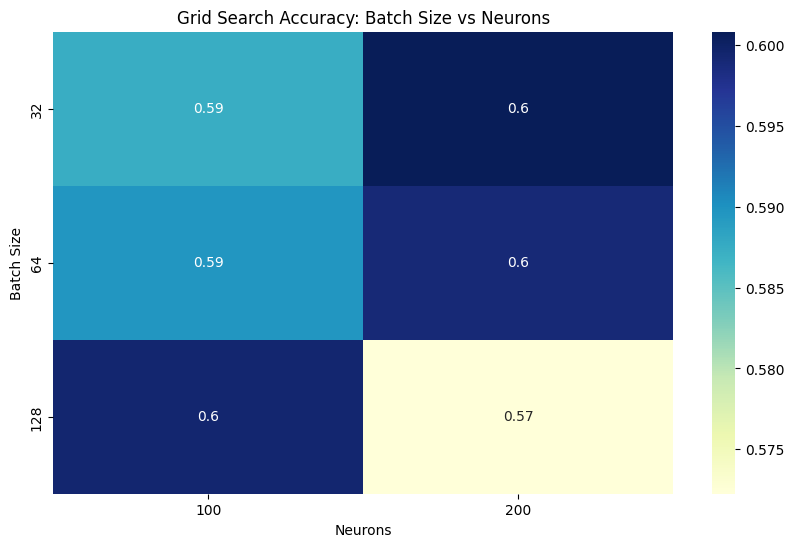

In [20]:
# Output the best parameters and score
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

# Retrieve cross-validation results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# Print mean and std of each configuration
for mean, std, param in zip(means, stds, params):
    print(f"Mean Accuracy: {mean:.4f} (std: {std:.4f}) with params: {param}")

# Evaluate on test data
best_model = grid.best_estimator_
test_accuracy = best_model.score(X_test, y_test_categorical)
print(f"Test Accuracy: {test_accuracy}")

# Visualizing Grid Search Results with a Heatmap
batch_size_values = param_grid['batch_size']
neurons_values = param_grid['neurons']

heatmap_data = np.zeros((len(batch_size_values), len(neurons_values)))

for i, batch_size in enumerate(batch_size_values):
    for j, neurons in enumerate(neurons_values):
        for mean, param in zip(means, params):
            if param['batch_size'] == batch_size and param['neurons'] == neurons:
                heatmap_data[i, j] = mean

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, xticklabels=neurons_values, yticklabels=batch_size_values, cmap="YlGnBu")
plt.title('Grid Search Accuracy: Batch Size vs Neurons')
plt.xlabel('Neurons')
plt.ylabel('Batch Size')
plt.show()

In [21]:
best_two_means = means[:2]  # Taking top two configurations
best_two_stds = stds[:2]  # Corresponding standard deviations

# Perform t-test between two sets of accuracy scores
t_stat, p_value = stats.ttest_ind_from_stats(mean1=best_two_means[0], std1=best_two_stds[0], nobs1=3,
                                             mean2=best_two_means[1], std2=best_two_stds[1], nobs2=3)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference between the two hyperparameter sets.")
else:
    print("There is no significant difference between the two hyperparameter sets.")


T-statistic: 1.03873388337139, P-value: 0.3575918716853783
There is no significant difference between the two hyperparameter sets.


In [58]:
class RPropOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, initial_lr=0.01, delta_min=1e-6, delta_max=50.0, eta_plus=1.2, eta_minus=0.5, name="RProp", **kwargs):
        super(RPropOptimizer, self).__init__(name=name, **kwargs)
        self.initial_lr = initial_lr
        self.delta_min = delta_min
        self.delta_max = delta_max
        self.eta_plus = eta_plus
        self.eta_minus = eta_minus
        self._slots = {}

    def _create_slots(self, var_list):
        # Create slots for previous gradients and delta
        for var in var_list:
            # Initialize previous_gradient and delta for each variable as a TensorFlow variable
            self._slots.setdefault(var.ref(), {})["previous_gradient"] = tf.Variable(tf.zeros_like(var), trainable=False)
            self._slots.setdefault(var.ref(), {})["delta"] = tf.Variable(tf.fill(var.shape, self.initial_lr), trainable=False)

    def update_step(self, grad, var, learning_rate=None):
        # Retrieve the previous gradient and delta from the slots
        prev_grad = self._slots.get(var.ref(), {}).get("previous_gradient")
        delta = self._slots.get(var.ref(), {}).get("delta")

        if prev_grad is None or delta is None:
            # If the slots haven't been initialized yet, initialize them
            self._slots.setdefault(var.ref(), {})["previous_gradient"] = tf.Variable(tf.zeros_like(var), trainable=False)
            self._slots.setdefault(var.ref(), {})["delta"] = tf.Variable(tf.fill(var.shape, self.initial_lr), trainable=False)
            prev_grad = self._slots[var.ref()]["previous_gradient"]
            delta = self._slots[var.ref()]["delta"]

        # Calculate sign changes
        new_grad = tf.sign(grad)
        sign_change = tf.sign(prev_grad * grad)

        # Update delta based on sign change
        delta_t = tf.where(
            sign_change > 0,
            tf.minimum(delta * self.eta_plus, self.delta_max),
            tf.where(sign_change < 0, tf.maximum(delta * self.eta_minus, self.delta_min), delta)
        )

        # Apply the weight update only if the gradient sign is non-negative
        delta_update = tf.where(sign_change >= 0, new_grad * delta_t, 0.0)
        var.assign_sub(delta_update)

        delta.assign(delta_t)
        prev_grad.assign(grad)

    def _resource_apply_dense(self, grad, var, apply_state=None):
        self.update_step(grad, var)

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "delta_min": self.delta_min,
            "delta_max": self.delta_max,
            "eta_plus": self.eta_plus,
            "eta_minus": self.eta_minus,
        }

In [90]:
class HybridOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, adam_optimizer, rprop_optimizer, name="Hybrid", **kwargs):
        super(HybridOptimizer, self).__init__(name=name, **kwargs)
        self.adam_optimizer = adam_optimizer
        self.rprop_optimizer = rprop_optimizer

    def _create_slots(self, var_list):
        self.adam_optimizer._create_slots(var_list)
        self.rprop_optimizer._create_slots(var_list)

    def apply_gradients(self, grads_and_vars, name=None):
        # Compute gradients using Adam optimizer
        adam_grads_and_vars = self.adam_optimizer.get_gradients(grads_and_vars)

        # Compute gradients using RProp optimizer
        rprop_grads_and_vars = self.rprop_optimizer.get_gradients(grads_and_vars)

        # Average the gradients from both optimizers
        combined_grads_and_vars = []
        for (grad1, var1), (grad2, var2) in zip(adam_grads_and_vars, rprop_grads_and_vars):
            if var1.ref() == var2.ref():
                combined_grad = tf.add(grad1, grad2) / 2.0
                combined_grads_and_vars.append((combined_grad, var1))

        # Apply the combined gradients
        return self.adam_optimizer.apply_gradients(combined_grads_and_vars, name=name)

    def get_config(self):
        return {
            "adam_optimizer": self.adam_optimizer.get_config(),
            "rprop_optimizer": self.rprop_optimizer.get_config(),
        }


In [95]:
# Define Adam and RProp optimizers for each model
def create_optimizers():
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    rprop_optimizer = RPropOptimizer(initial_lr=0.01, learning_rate=0.001)
    hybrid_optimizer = HybridOptimizer(adam_optimizer, rprop_optimizer,learning_rate=0.001,name="Hybrid")
    return adam_optimizer, rprop_optimizer, hybrid_optimizer


In [97]:
adam_optimizer, rprop_optimizer, hybrid_optimizer = create_optimizers()
# Train the model using Adam optimizer
adam_model = KerasClassifierWrapper(
    build_fn=create_classification_model,
    optimizer=adam_optimizer,
    epochs=100,
    batch_size=32
)
adam_history = adam_model.fit(X_train, y_train_categorical)

# Evaluate models
adam_test_accuracy = adam_model.score(X_test, y_test_categorical)
print(f"Test accuracy with Adam optimizer: {adam_test_accuracy}")

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use

Test accuracy with Adam optimizer: 0.6969696879386902


In [98]:
adam_optimizer, rprop_optimizer, hybrid_optimizer = create_optimizers()
# Train the model using RProp optimizer
rprop_model = KerasClassifierWrapper(
    build_fn=create_classification_model,
    optimizer=rprop_optimizer,
    epochs=100,
    batch_size=32
)
rprop_history = rprop_model.fit(X_train, y_train_categorical)

rprop_test_accuracy = rprop_model.score(X_test, y_test_categorical)
print(f"Test accuracy with RProp optimizer: {rprop_test_accuracy}")

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use

Test accuracy with RProp optimizer: 0.5240641832351685


In [99]:
adam_optimizer, rprop_optimizer, hybrid_optimizer = create_optimizers()
# Train the model using Hybrid optimizer
hybrid_model = KerasClassifierWrapper(
    build_fn=create_classification_model,
    optimizer=hybrid_optimizer,
    epochs=100,
    batch_size=32
)
hybrid_history = hybrid_model.fit(X_train, y_train_categorical)

hybrid_test_accuracy = hybrid_model.score(X_test, y_test_categorical)
print(f"Test accuracy with Hybrid optimizer: {hybrid_test_accuracy}")

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


AttributeError: 'Adam' object has no attribute 'get_gradients'

In [100]:
import matplotlib.pyplot as plt

def plot_loss_curves(adam_history, rprop_history, hybrid_history):
    adam_train_loss = adam_history.history['loss']
    adam_val_loss = adam_history.history['val_loss']

    rprop_train_loss = rprop_history.history['loss']
    rprop_val_loss = rprop_history.history['val_loss']

    hybrid_train_loss = hybrid_history.history['loss']
    hybrid_val_loss = hybrid_history.history['val_loss']

    plt.figure(figsize=(10, 6))
    plt.plot(adam_train_loss, label='Adam - Training Loss', color='blue', linestyle='--')
    plt.plot(adam_val_loss, label='Adam - Validation Loss', color='blue', linestyle='-')

    plt.plot(rprop_train_loss, label='RProp - Training Loss', color='green', linestyle='--')
    plt.plot(rprop_val_loss, label='RProp - Validation Loss', color='green', linestyle='-')

    plt.plot(hybrid_train_loss, label='Hybrid - Training Loss', color='red', linestyle='--')
    plt.plot(hybrid_val_loss, label='Hybrid - Validation Loss', color='red', linestyle='-')

    plt.title('Training and Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()